In [1]:
import lucid
import lucid.nn as nn
import lucid.nn.functional as F
import lucid.optim as optim
import lucid.data as data
import lucid.datasets as datasets
import lucid.models as models

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
batch_size = 64
learning_rate = 1e-4
num_epochs = 50
latent_dim = 20

lucid.random.seed(42)

In [3]:
train_set = datasets.FashionMNIST(root="../../data/fashion_mnist", train=True)
test_set = datasets.FashionMNIST(root="../../data/fashion_mnist",train=False)

In [4]:
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2_mean = nn.Linear(500, latent_dim)
        self.fc2_logvar = nn.Linear(500, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 500)
        self.fc4 = nn.Linear(500, 784)
    
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mean = self.fc2_mean(h1)
        logvar = self.fc2_logvar(h1).clip(-10.0, 10.0)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = lucid.exp(0.5 * logvar)
        eps = lucid.random.randn(std.shape)
        return mean + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

In [6]:
def loss_function(recon_x, x, mean, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * lucid.sum(1 + logvar - mean ** 2 - lucid.exp(logvar))
    return BCE + KLD

In [7]:
def normalize(x):
    norm = x.astype(lucid.Float) / 255.0
    return norm.reshape(-1, 784)

In [8]:
def train(model, train_loader, optimizer, num_epochs):
    losses = []
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for data, _ in progress_bar:
            optimizer.zero_grad()
            data = normalize(data)
            recon_batch, mean, logvar = model(data)

            loss = loss_function(recon_batch, data, mean, logvar)
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            losses.append(batch_loss)
            epoch_loss += batch_loss
            progress_bar.set_postfix(loss=batch_loss)
    
    return losses

In [9]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    losses = []
    with lucid.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing")
        for data, _ in progress_bar:
            recon_batch, mean, logvar = model(data)
            loss = loss_function(recon_batch, data, mean, logvar).eval()
            batch_loss = loss.item()

            test_loss += batch_loss
            losses.append(batch_loss)
            progress_bar.set_postfix(loss=batch_loss)
    
    avg_loss = test_loss / len(test_loader)
    print(f"\nAverage Test Loss: {avg_loss:.4f}")
    return losses

In [10]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

models.summarize(model, input_shape=(1, 784))

                                        Summary of VAE                                         
Layer                               Input Shape           Output Shape          Parameter Size
VAE                                 (1, 784)              None                  815,824     
├── Linear                          (1, 500)              (1, 784)              392,784     
├── Linear                          (1, 20)               (1, 500)              10,500      
├── Linear                          (1, 500)              (1, 20)               10,020      
├── Linear                          (1, 500)              (1, 20)               10,020      
├── Linear                          (1, 784)              (1, 500)              392,500     
Total Layers(Submodules): 5
Total Parameters: 815,824 (815.82K)
Total FLOPs: 827,276 (827.28K)


In [11]:
train_losses = train(model, train_loader, optimizer, num_epochs)

Epoch 50/50: 100%|██████████| 875/875 [00:17<00:00, 50.13it/s, loss=1.57e+4]


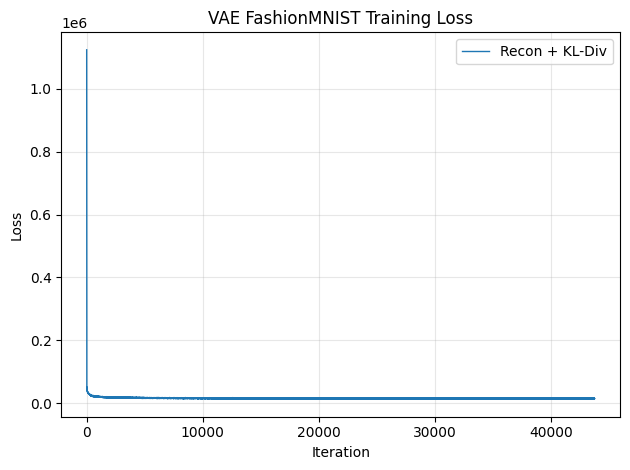

In [12]:
plt.plot(train_losses, lw=1, label="Recon + KL-Div")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("VAE FashionMNIST Training Loss")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

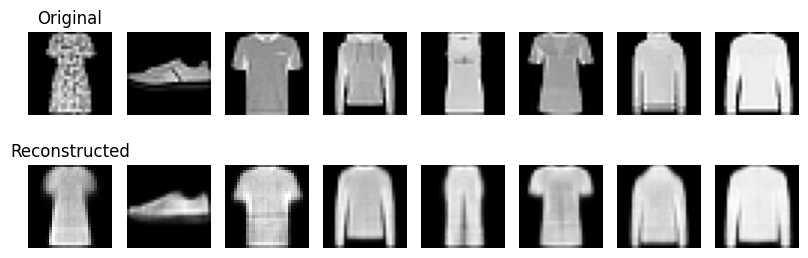

In [13]:
model.eval()
data_batch, _ = next(iter(test_loader))
data_batch = normalize(data_batch)
recon_batch, _, _ = model(data_batch[:8])

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 8, figsize=(8, 3))
for i in range(8):
    axes[0, i].imshow(data_batch[i].reshape(28, 28).data, cmap='gray')
    axes[1, i].imshow(recon_batch[i].reshape(28, 28).data, cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')

axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")
plt.tight_layout()

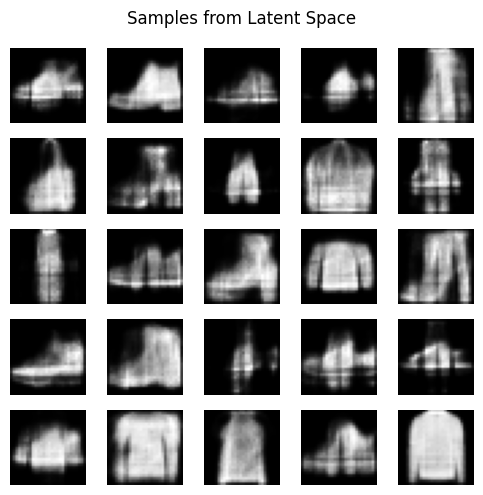

In [14]:
z = lucid.random.randn(25, 20)
samples = model.decode(z)

fig, axes = plt.subplots(5, 5, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].reshape(28, 28).data, cmap='gray')
    ax.axis("off")

plt.suptitle("Samples from Latent Space")
plt.tight_layout()